## Anomaly Detection in Particle Physics Using AI at the LHC

*Jordan Pfeifer, Ekin Secilmis, Egor Serebriakov*

> **This notebook is for the evaluation stage of the project**

In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, random_split, DataLoader
from torch import nn
import pandas as pd

In [2]:
# For aesthetics/plotting.
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
plt.style.use("seaborn-v0_8")

In [3]:
# Load "backend".
from preprocess import AnomalyDetectionDataset, device_change, load_anomaly_dataset_csv
from model import AutoencoderAnomalyDetection, evaluate_model, TransformerAnomalyDetection

In [4]:
# Working directory.
data_dir = '/users/eserebri/data/eserebri/PHYS2550FinalProject/anomaly detection'

In [5]:
# Switch to GPU if there is one.
device = device_change()

Using cuda device


### Load Data as $\texttt{tf.utils.DataLoader}$

In [6]:
file_names = {
    'background': 'X_test', 
    'first_box': 'X_test_first',
    'second_box': 'X_test_second',
    'third_box': 'X_test_third'
}
# file_name = {'background': 'X_test_small'}
batch_size = 350

In [7]:
data = load_anomaly_dataset_csv(
    file_name=file_names,
    file_directory=f'{data_dir}', 
    batch_size=batch_size, 
)

In [8]:
data

{'background': <torch.utils.data.dataloader.DataLoader at 0x7fb894bfb910>,
 'first_box': <torch.utils.data.dataloader.DataLoader at 0x7fb828d7a250>,
 'second_box': <torch.utils.data.dataloader.DataLoader at 0x7fb828dd7d50>,
 'third_box': <torch.utils.data.dataloader.DataLoader at 0x7fb82880c8d0>}

### Model Evaluation

In [9]:
# Load model parameters.
PATH = f'{data_dir}/model_par/autoencoder_state_dict.pth'
model = AutoencoderAnomalyDetection().to(device)
model.load_state_dict(torch.load(PATH))
loss_function = nn.MSELoss()

In [10]:
# Make predictions.
loss = {}
for key, value in data.items():
    loss_current = evaluate_model(
        dataloader_test=value,
        model=model,
        loss_func=loss_function,
        batch_size=batch_size
    )
    loss.update({key: loss_current})

### Plot Results

In [11]:
# Set threshold and save plots option.
threshold = 3 * loss['background'].std() + loss['background'].mean()
save = False
threshold

12.04017317456195

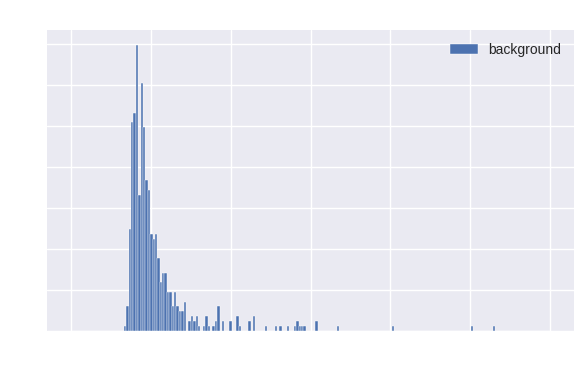

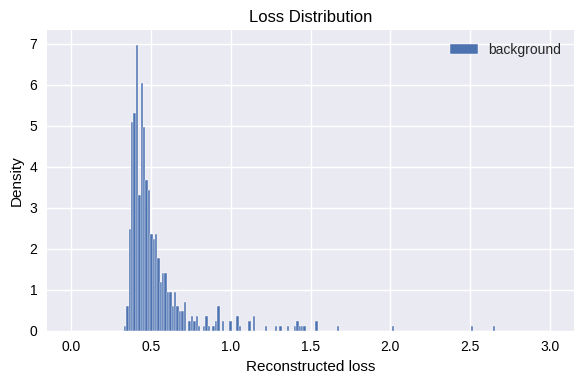

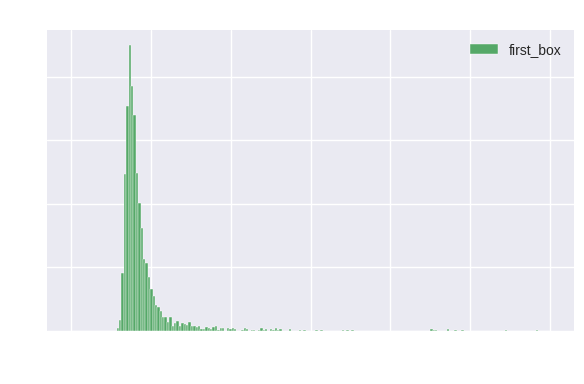

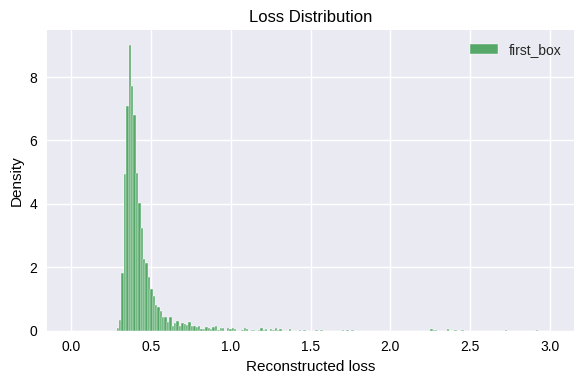

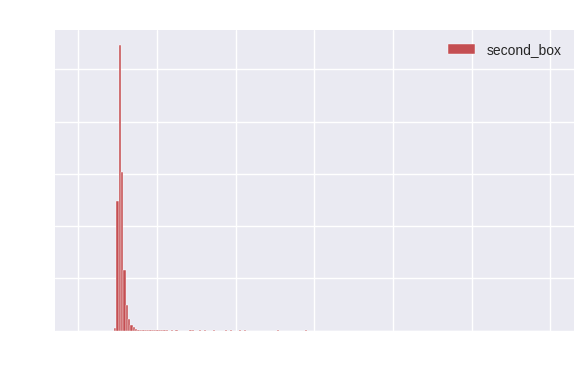

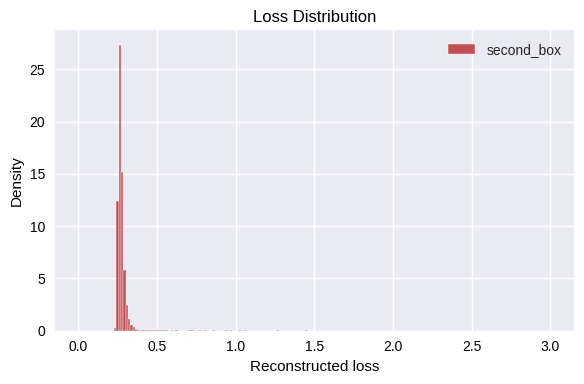

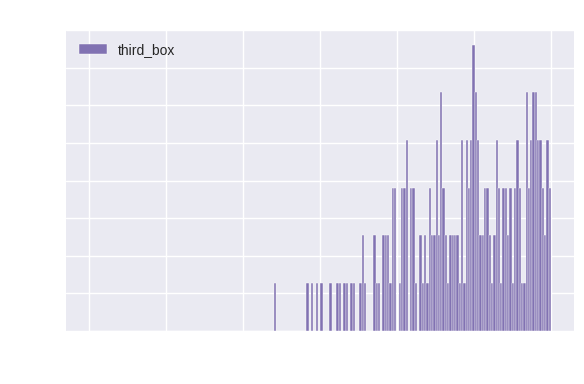

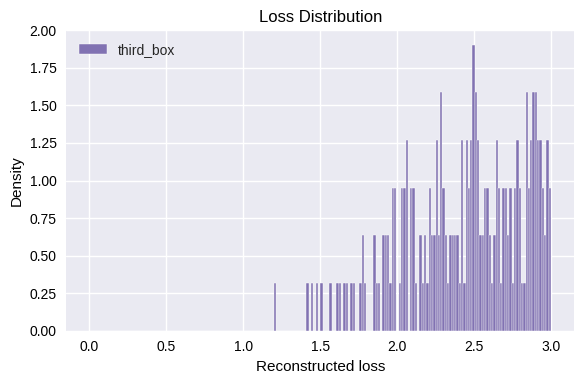

In [12]:
# Plot loss density (separately).
graph_text_face = [('white', 'none'), ('black', 'white')]
c = 0
for key, value in loss.items():
    for (text_color, face_color) in graph_text_face:
        fig, ax = plt.subplots(figsize=(6, 4), facecolor=face_color)
        plt.hist(value, range=(0,3), bins=200, label=f'{key}', density=True, color=sns.color_palette()[c])
        ax.set_title("Loss Distribution", color=text_color)
        ax.set_xlabel("Reconstructed loss", color=text_color)
        ax.set_ylabel("Density", color=text_color)
        plt.legend()
        ax.tick_params(axis='both', colors=text_color)
        plt.tight_layout()
        if save: plt.savefig(f'{data_dir}/graphs/{key}_density_{face_color}.png', dpi=600, bbox_inches='tight')
        plt.show()
    c += 1

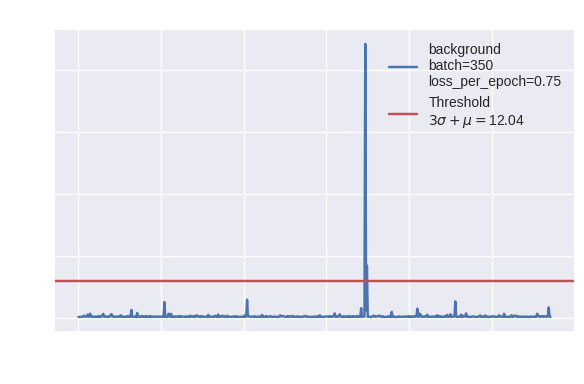

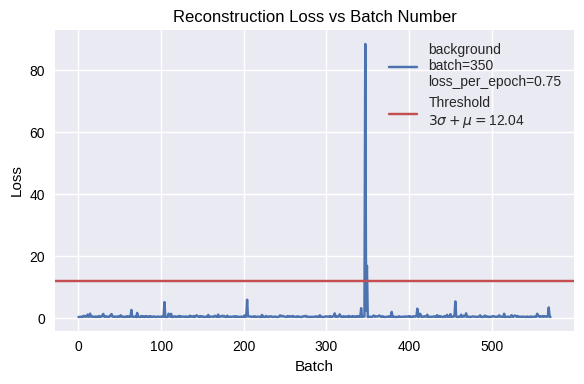

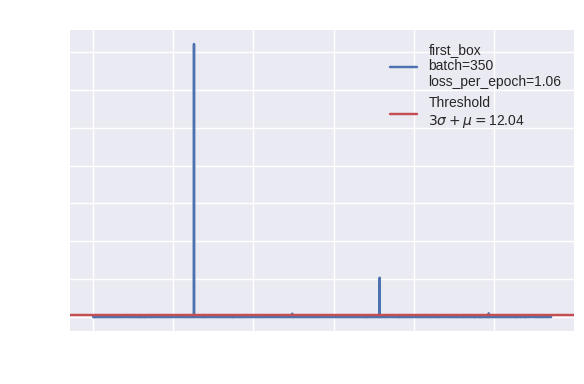

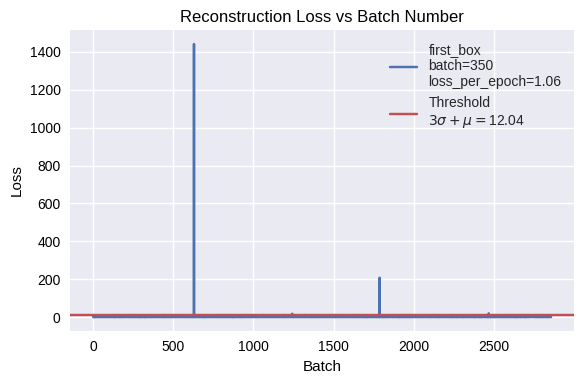

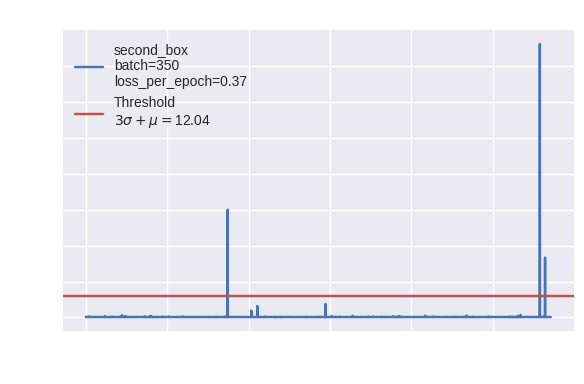

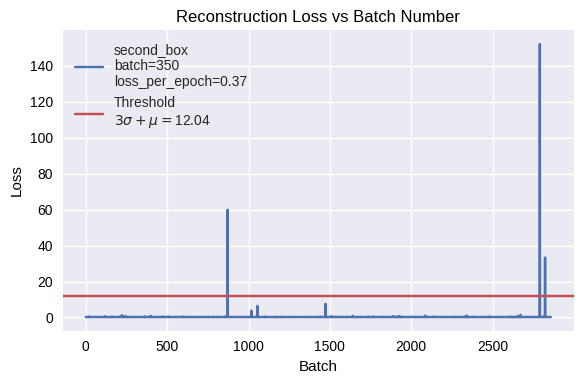

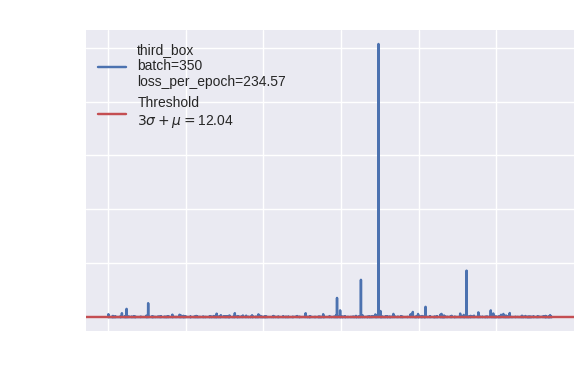

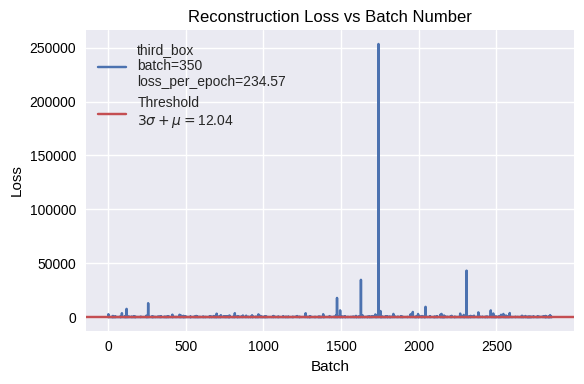

In [13]:
# Plot Batch vs Loss (linear/separately).
for key, value in loss.items():
    for (text_color, face_color) in graph_text_face:
        fig, ax = plt.subplots(figsize=(6, 4), facecolor=face_color)
        plt.plot(value, label=f'{key}\nbatch={batch_size}\nloss_per_epoch={value.mean():.2f}')
        plt.axhline(threshold, color=sns.color_palette()[2], label=f'Threshold\n$3\sigma+\mu=${threshold:.2f}')
        ax.set_title("Reconstruction Loss vs Batch Number", color=text_color)
        plt.legend()
        ax.set_xlabel("Batch", color=text_color)
        ax.set_ylabel("Loss", color=text_color)
        ax.legend(facecolor=face_color)
        ax.tick_params(axis='both', colors=text_color)
        plt.tight_layout()
        # plt.yscale("log")
        if save: plt.savefig(f'{data_dir}/graphs/{key}_loss_linear_batch_{face_color}.png', dpi=600, bbox_inches='tight')
        plt.show()

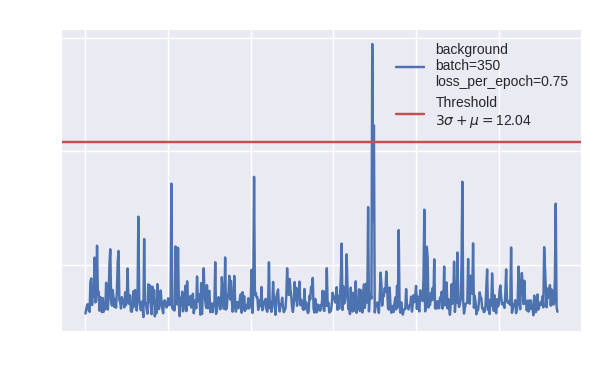

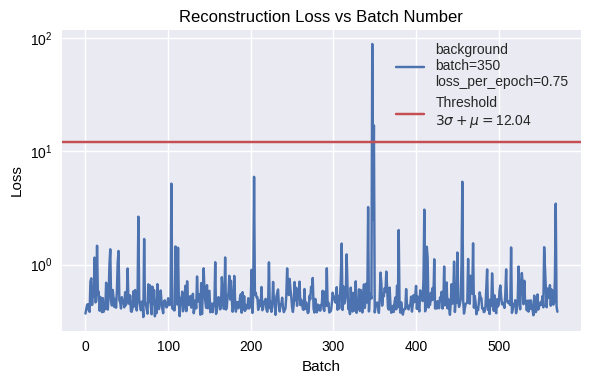

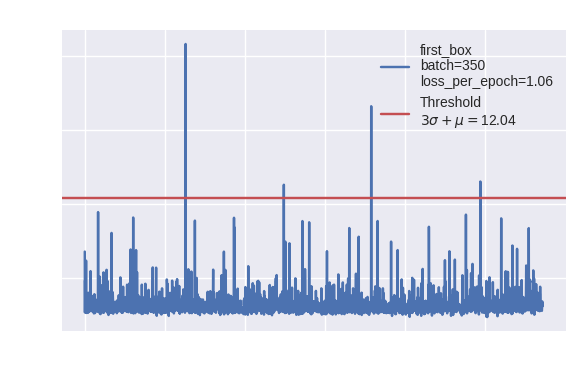

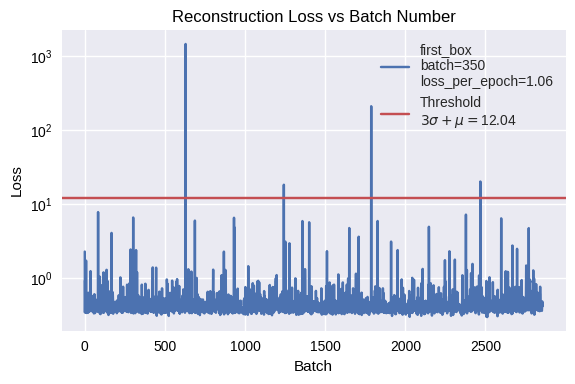

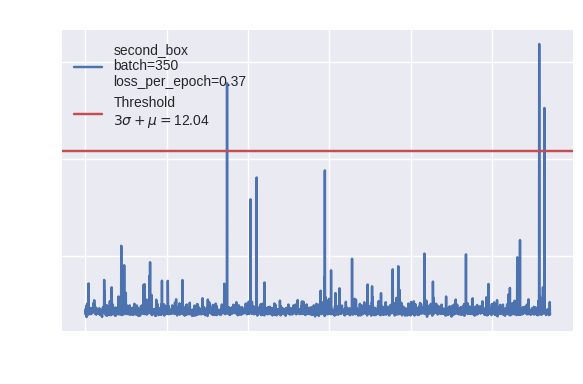

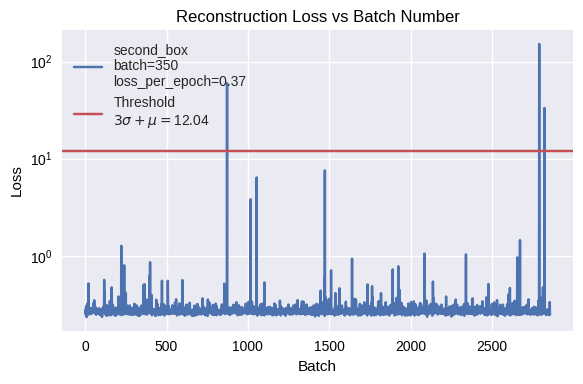

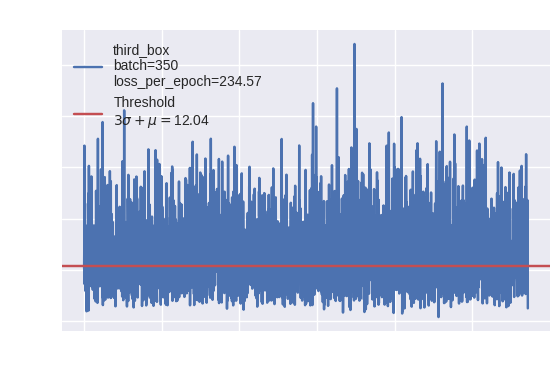

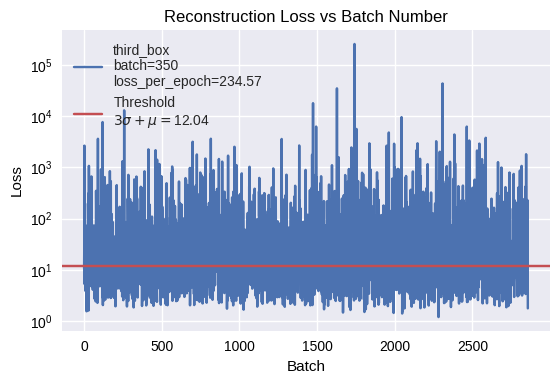

In [14]:
# Plot Batch vs Loss (log/separately).
for key, value in loss.items():
    for (text_color, face_color) in graph_text_face:
        fig, ax = plt.subplots(figsize=(6, 4), facecolor=face_color)
        plt.plot(value, label=f'{key}\nbatch={batch_size}\nloss_per_epoch={value.mean():.2f}')
        plt.axhline(threshold, color=sns.color_palette()[2], label=f'Threshold\n$3\sigma+\mu=${threshold:.2f}')
        ax.set_title("Reconstruction Loss vs Batch Number", color=text_color)
        plt.legend()
        ax.set_xlabel("Batch", color=text_color)
        ax.set_ylabel("Loss", color=text_color)
        ax.legend(facecolor=face_color)
        ax.tick_params(axis='both', colors=text_color)
        plt.tight_layout()
        plt.yscale("log")
        if save: plt.savefig(f'{data_dir}/graphs/{key}_loss_log_batch_{face_color}.png', dpi=600, bbox_inches='tight')
        plt.show()

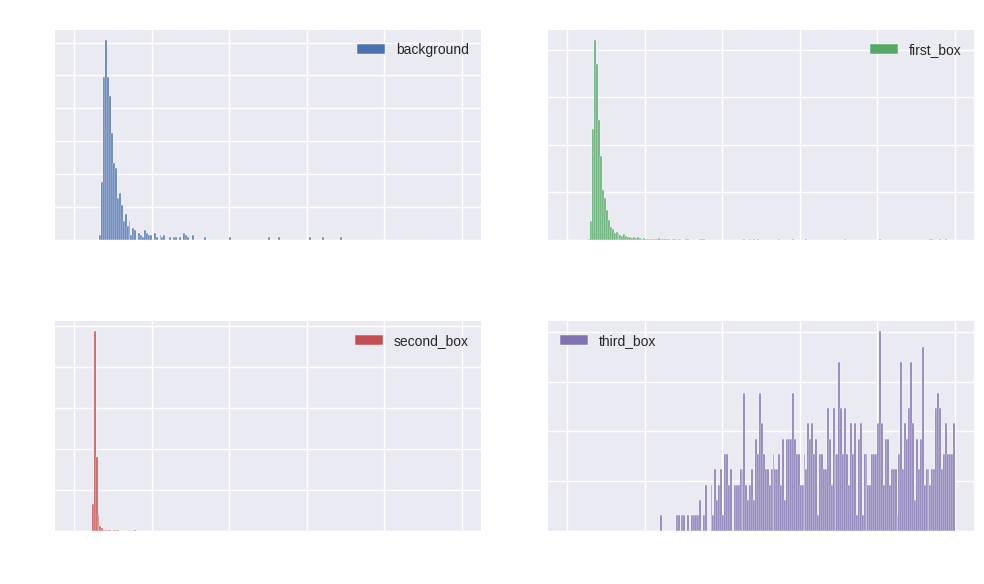

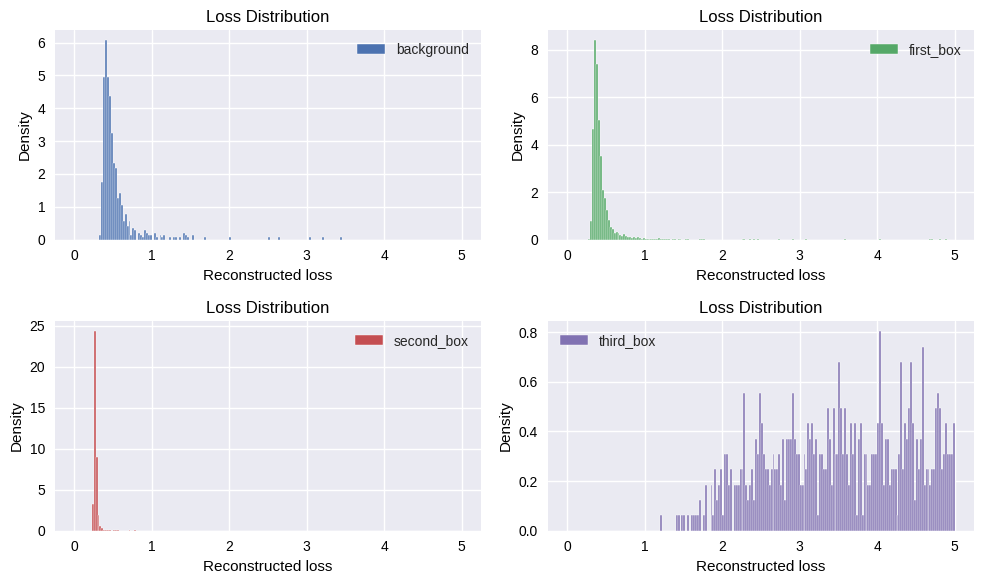

In [15]:
# Plot loss density (together).
for (text_color, face_color) in graph_text_face:
    fig, axs = plt.subplots(2, 2, figsize=(10, 6), facecolor=face_color)
    axs = axs.flatten()
    for ind, (key, value) in enumerate(loss.items()):
        ax = axs[ind]
        ax.hist(value, range=(0,5), bins=200, label=f'{key}', density=True, color=sns.color_palette()[ind])
        ax.set_title("Loss Distribution", color=text_color)
        ax.set_xlabel("Reconstructed loss", color=text_color)
        ax.set_ylabel("Density", color=text_color)
        ax.legend(facecolor=face_color)
        ax.tick_params(axis='both', colors=text_color)
    plt.tight_layout()
    if save: plt.savefig(f'{data_dir}/graphs/all_density_{face_color}.png', dpi=600, bbox_inches='tight')
    plt.show()

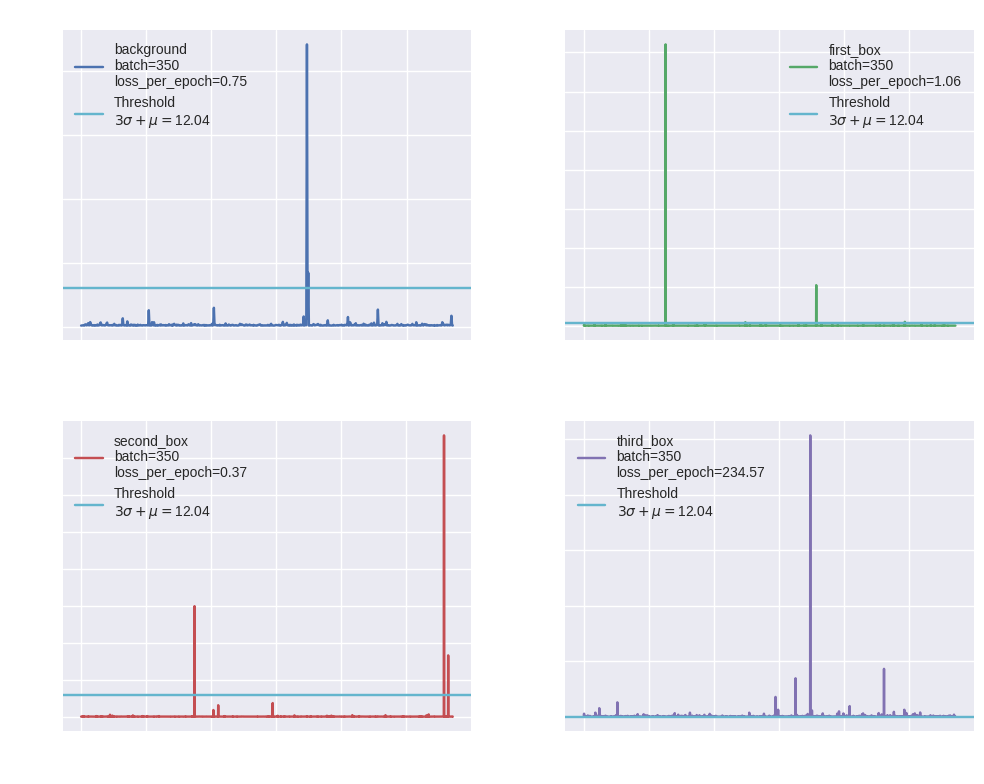

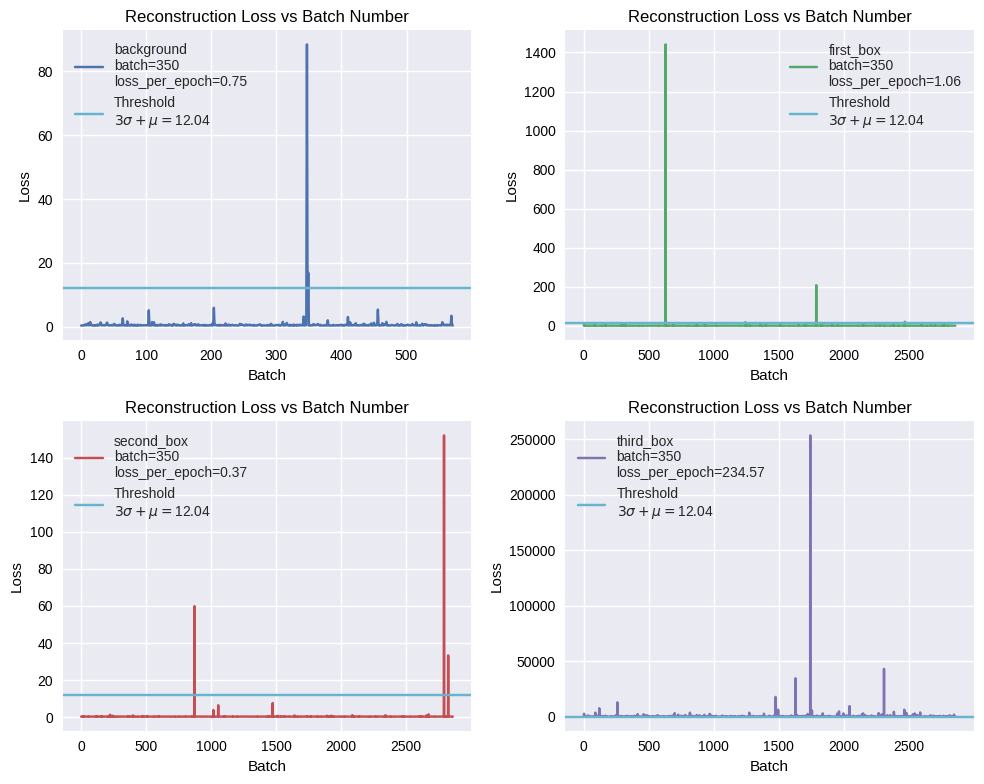

In [16]:
# Plot Batch vs Loss (linear/together).
for (text_color, face_color) in graph_text_face:
    fig, axs = plt.subplots(2, 2, figsize=(10, 8), facecolor=face_color)
    axs = axs.flatten()
    for ind, (key, value) in enumerate(loss.items()):
        ax = axs[ind]
        ax.plot(value, label=f'{key}\nbatch={batch_size}\nloss_per_epoch={value.mean():.2f}', color=sns.color_palette()[ind])
        ax.axhline(threshold, color=sns.color_palette()[5], label=f'Threshold\n$3\sigma+\mu=${threshold:.2f}')
        ax.set_title("Reconstruction Loss vs Batch Number", color=text_color)
        ax.set_xlabel("Batch", color=text_color)
        ax.set_ylabel("Loss", color=text_color)
        ax.legend(facecolor=face_color)
        ax.tick_params(axis='both', colors=text_color)
        # ax.set_yscale("log")
    plt.tight_layout()
    if save: plt.savefig(f'{data_dir}/graphs/all_loss_linear_batch_{face_color}.png', dpi=600, bbox_inches='tight')
    plt.show()

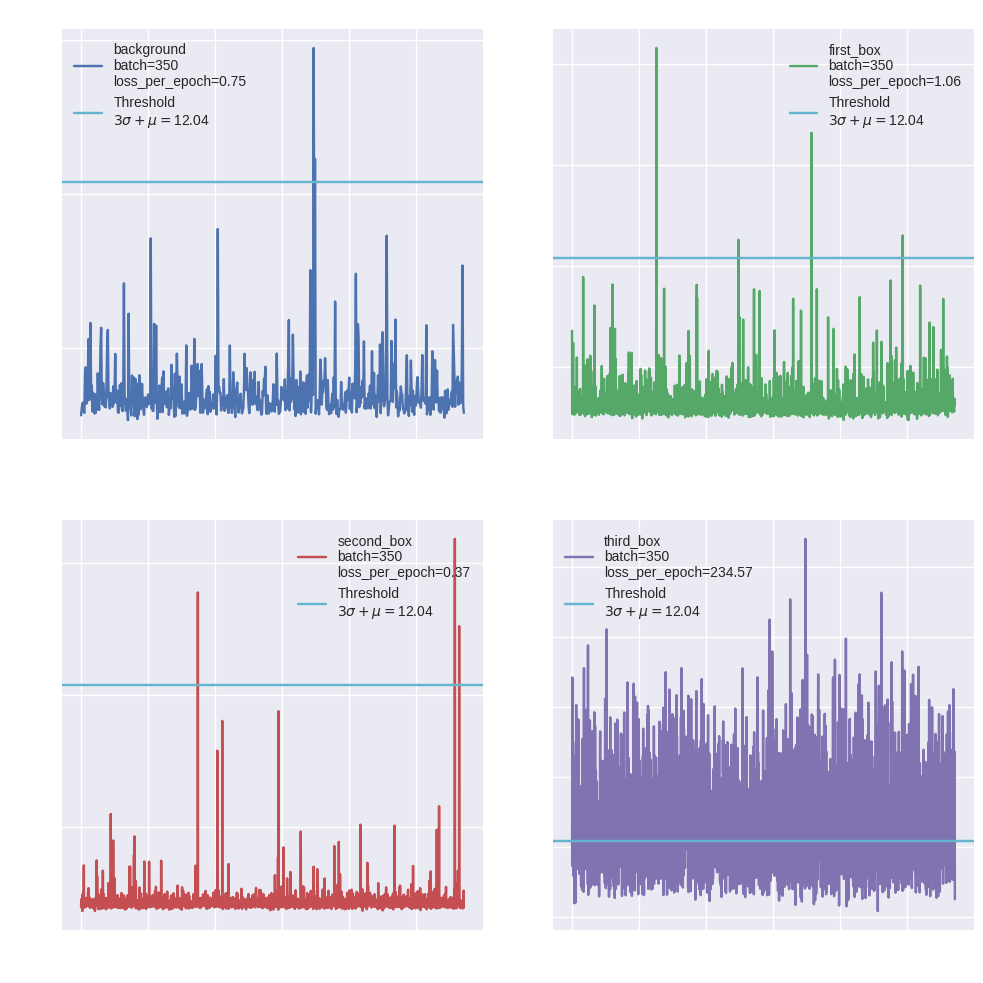

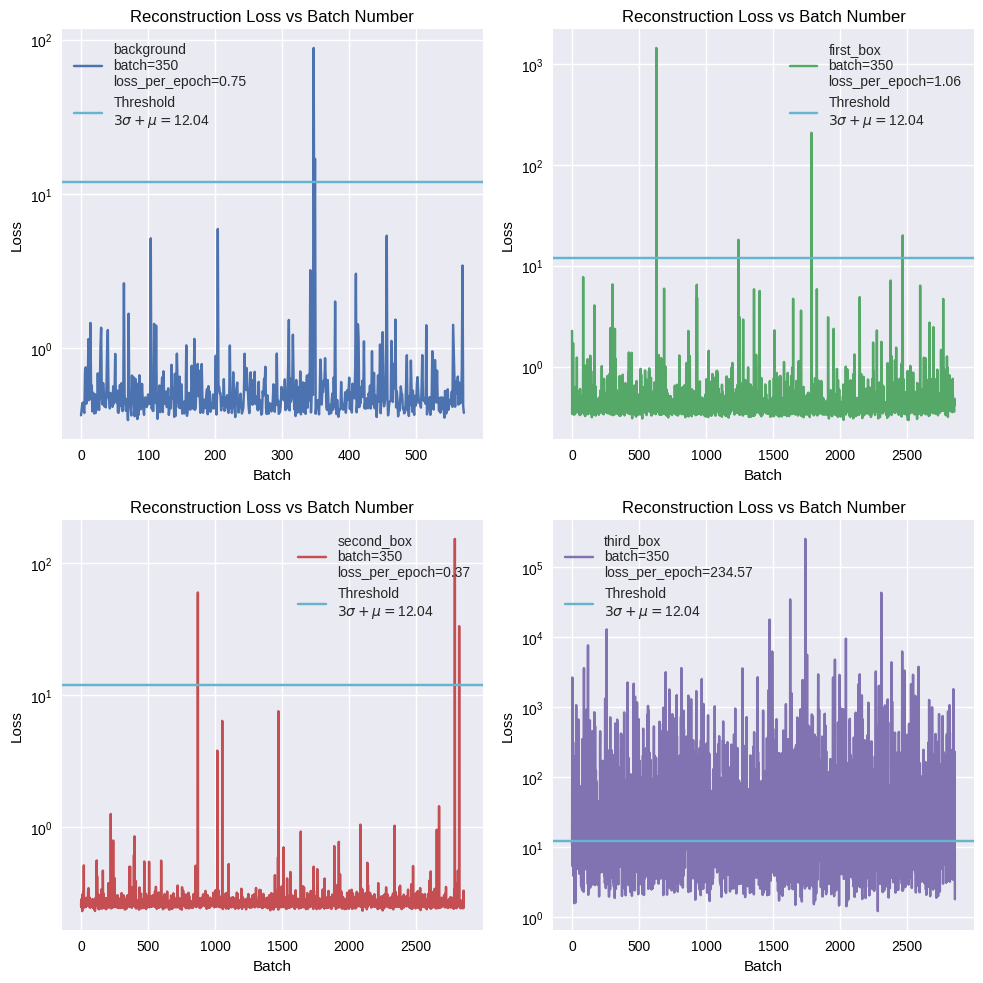

In [17]:
# Plot Batch vs Loss (log/together).
for (text_color, face_color) in graph_text_face:
    fig, axs = plt.subplots(2, 2, figsize=(10, 10), facecolor=face_color)
    axs = axs.flatten()
    for ind, (key, value) in enumerate(loss.items()):
        ax = axs[ind]
        ax.plot(value, label=f'{key}\nbatch={batch_size}\nloss_per_epoch={value.mean():.2f}', color=sns.color_palette()[ind])
        ax.axhline(threshold, color=sns.color_palette()[5], label=f'Threshold\n$3\sigma+\mu=${threshold:.2f}')
        ax.set_title("Reconstruction Loss vs Batch Number", color=text_color)
        ax.set_xlabel("Batch", color=text_color)
        ax.set_ylabel("Loss", color=text_color)
        ax.legend(facecolor=face_color)
        ax.tick_params(axis='both', colors=text_color)
        ax.set_yscale("log")
    plt.tight_layout()
    if save: plt.savefig(f'{data_dir}/graphs/all_loss_log_batch_{face_color}.png', dpi=600, bbox_inches='tight')
    plt.show()

### Unpack "Anomal" Batches

In [18]:
# Find "anomal" batches in each box.
anomaly_batches = {}
for key, value in loss.items():
    batch_num = []
    for ind, val in enumerate(value):
        if val > threshold:
            batch_num.append(ind)
    anomaly_batches.update({key: batch_num})

#### First Box

In [19]:
# Unpack 'anomal' batches in the first box.
num_batches_first = np.array(anomaly_batches['first_box'])
batches_first = {}
for ind, batch in enumerate(data['first_box']):
    if np.any(num_batches_first == ind):
        batches_first.update({f'ind {ind}': batch})
    elif ind > num_batches_first.max():
        break

In [20]:
# Make predictions again with batch=1.
loss_first = {}
for key, value in batches_first.items():
    loss_current = evaluate_model(
        dataloader_test=value,
        model=model,
        loss_func=loss_function,
        batch_size=1
    )
    loss_first.update({key: loss_current})

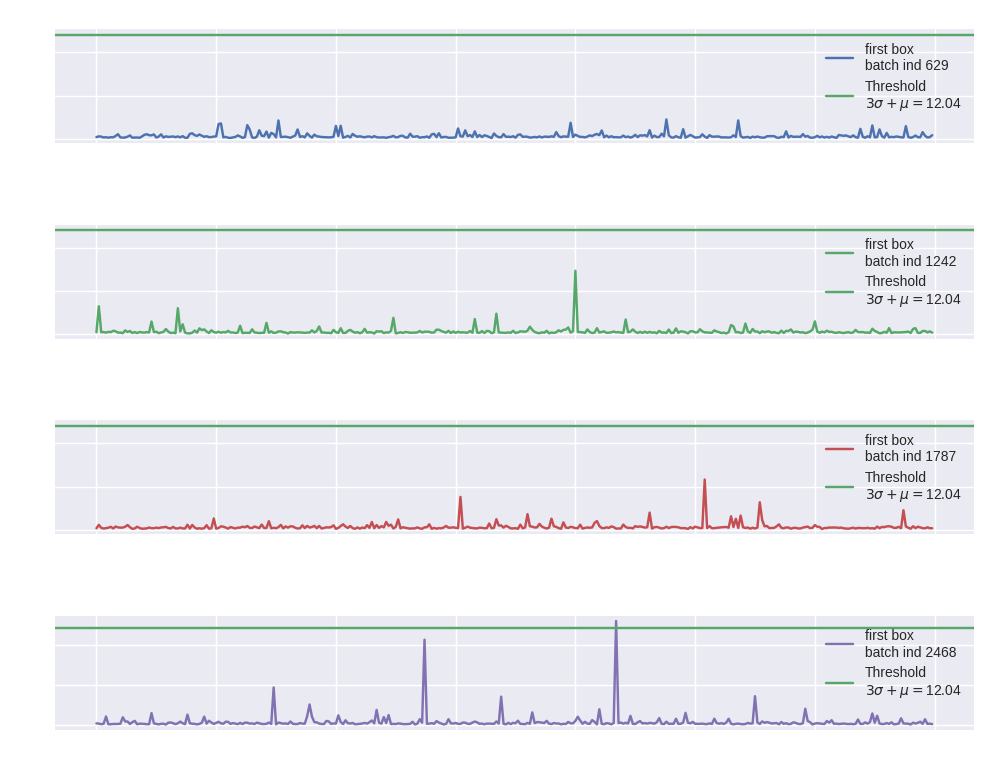

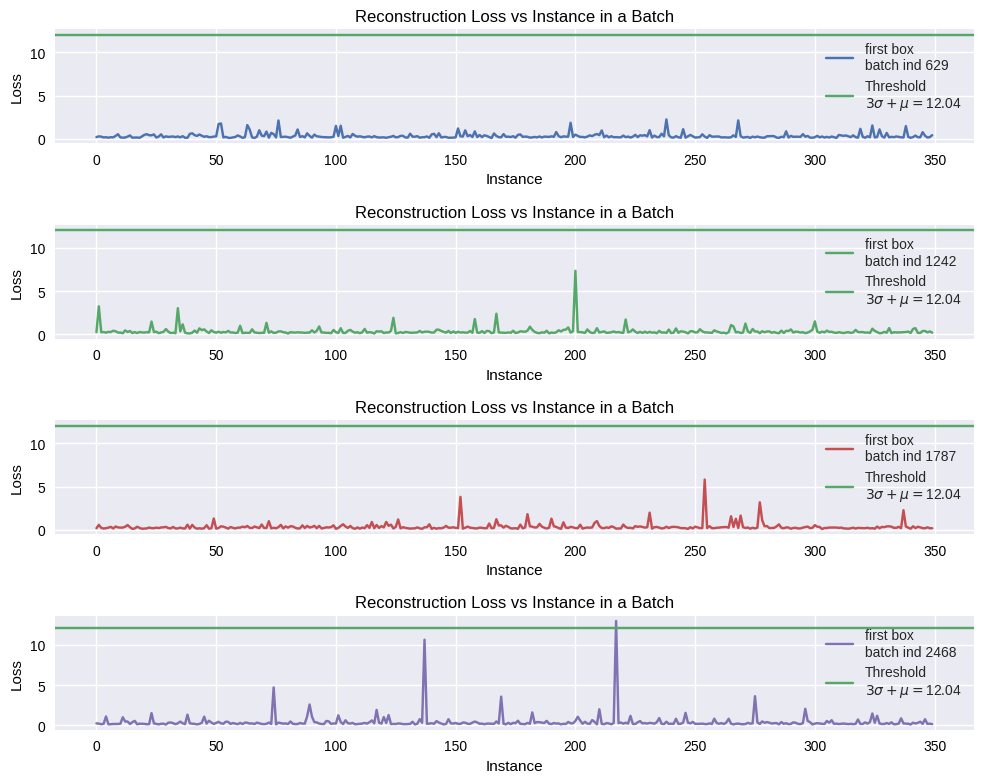

In [21]:
# Closer look at box one.
for (text_color, face_color) in graph_text_face:
    fig, axs = plt.subplots(4, figsize=(10, 8), facecolor=face_color)
    axs = axs.flatten()
    for ind, (key, value) in enumerate(loss_first.items()):
        ax = axs[ind]
        ax.plot(value, label=f'first box\nbatch {key}', color=sns.color_palette()[ind])
        ax.axhline(threshold, color=sns.color_palette()[1], label=f'Threshold\n$3\sigma+\mu=${threshold:.2f}')
        ax.set_title("Reconstruction Loss vs Instance in a Batch", color=text_color)
        ax.set_xlabel("Instance", color=text_color)
        ax.set_ylabel("Loss", color=text_color)
        ax.legend(facecolor=face_color)
        ax.tick_params(axis='both', colors=text_color)
        # ax.set_yscale("log")
    plt.tight_layout()
    if save: plt.savefig(f'{data_dir}/graphs/box_one_closer_{face_color}.png', dpi=600, bbox_inches='tight')
    plt.show()

#### Second Box

In [22]:
# Unpack 'anomal' batches in the second box.
num_batches_second = np.array(anomaly_batches['second_box'])
batches_second = {}
for ind, batch in enumerate(data['second_box']):
    if np.any(num_batches_second == ind):
        batches_second.update({f'ind {ind}': batch})
    elif ind > num_batches_second.max():
        break

In [23]:
# Make predictions again with batch=1.
loss_second = {}
for key, value in batches_second.items():
    loss_current = evaluate_model(
        dataloader_test=value,
        model=model,
        loss_func=loss_function,
        batch_size=1
    )
    loss_second.update({key: loss_current})

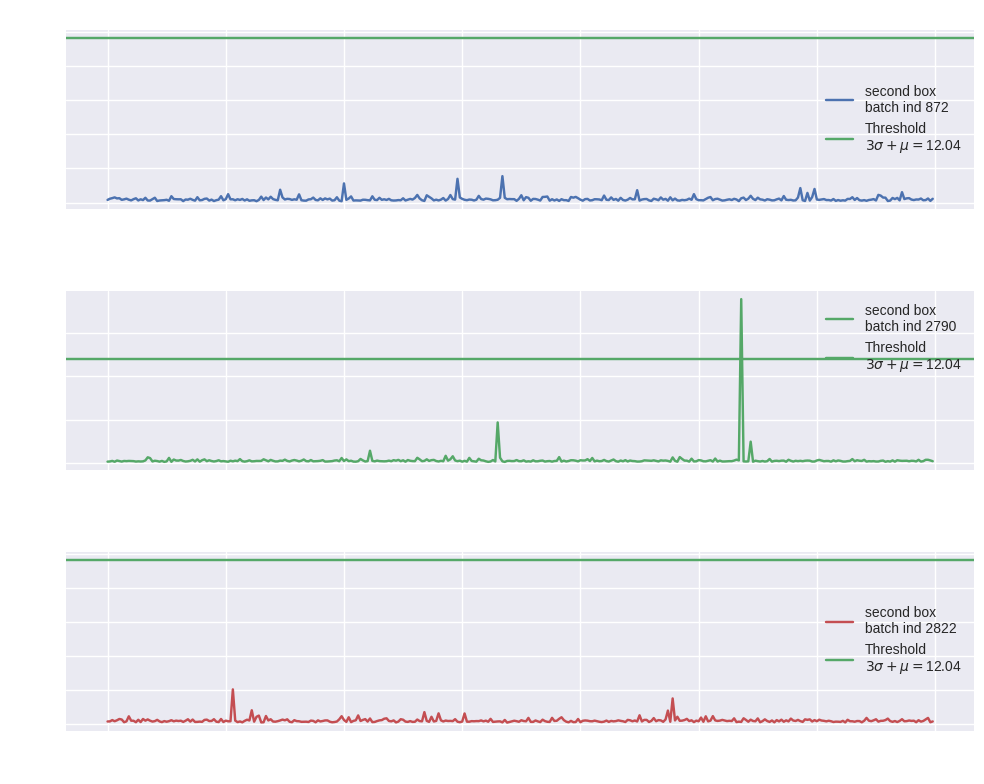

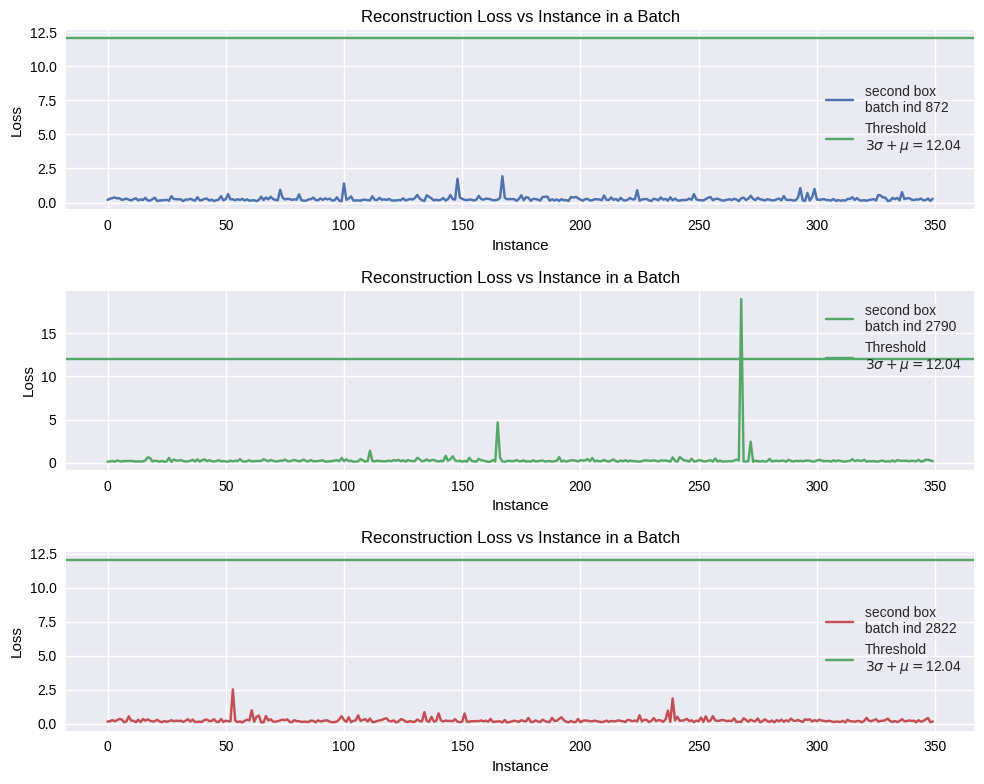

In [24]:
# Closer look at box two.
for (text_color, face_color) in graph_text_face:
    fig, axs = plt.subplots(3, figsize=(10, 8), facecolor=face_color)
    axs = axs.flatten()
    for ind, (key, value) in enumerate(loss_second.items()):
        ax = axs[ind]
        ax.plot(value, label=f'second box\nbatch {key}', color=sns.color_palette()[ind])
        ax.axhline(threshold, color=sns.color_palette()[1], label=f'Threshold\n$3\sigma+\mu=${threshold:.2f}')
        ax.set_title("Reconstruction Loss vs Instance in a Batch", color=text_color)
        ax.set_xlabel("Instance", color=text_color)
        ax.set_ylabel("Loss", color=text_color)
        ax.legend(facecolor=face_color)
        ax.tick_params(axis='both', colors=text_color)
        # ax.set_yscale("log")
    plt.tight_layout()
    if save: plt.savefig(f'{data_dir}/graphs/box_two_closer_{face_color}.png', dpi=600, bbox_inches='tight')
    plt.show()

### Third Box

In [25]:
# Unpack some 'anomal' batches in the third box.
np.random.seed(42)
num_batches_third = np.random.permutation(np.array(anomaly_batches['third_box']))
num_batches_third = num_batches_third[:4]
batches_third = {}
for ind, batch in enumerate(data['third_box']):
    if np.any(num_batches_third == ind):
        batches_third.update({f'ind {ind}': batch})

In [26]:
# Make predictions again with batch=1.
loss_third = {}
for key, value in batches_third.items():
    loss_current = evaluate_model(
        dataloader_test=value,
        model=model,
        loss_func=loss_function,
        batch_size=1
    )
    loss_third.update({key: loss_current})

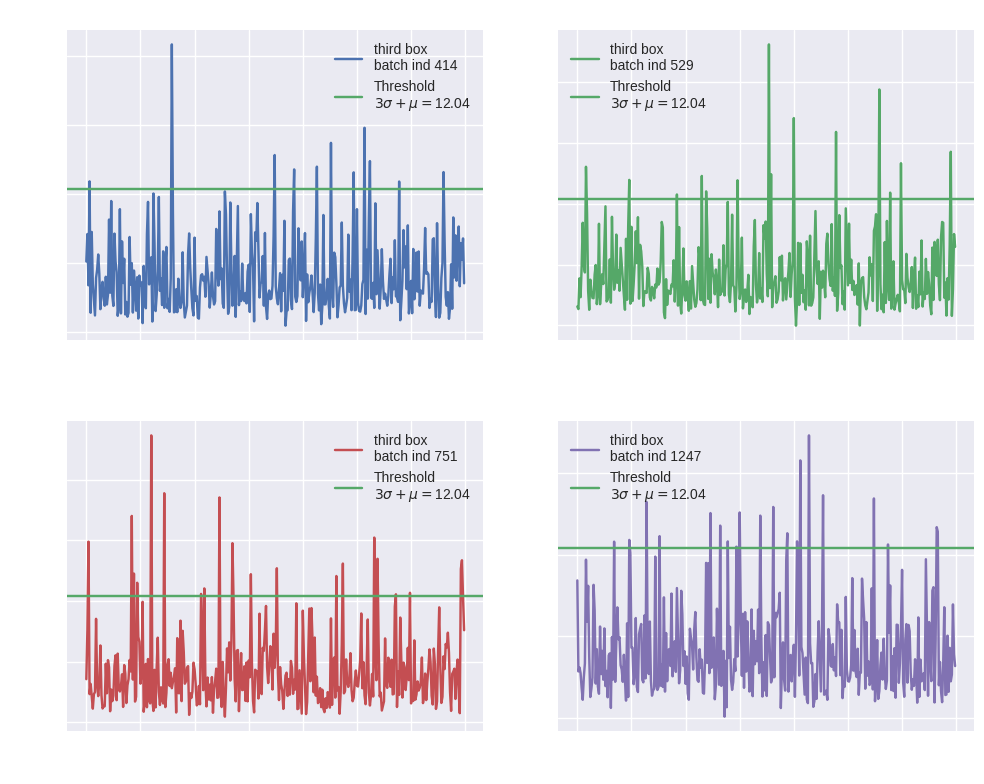

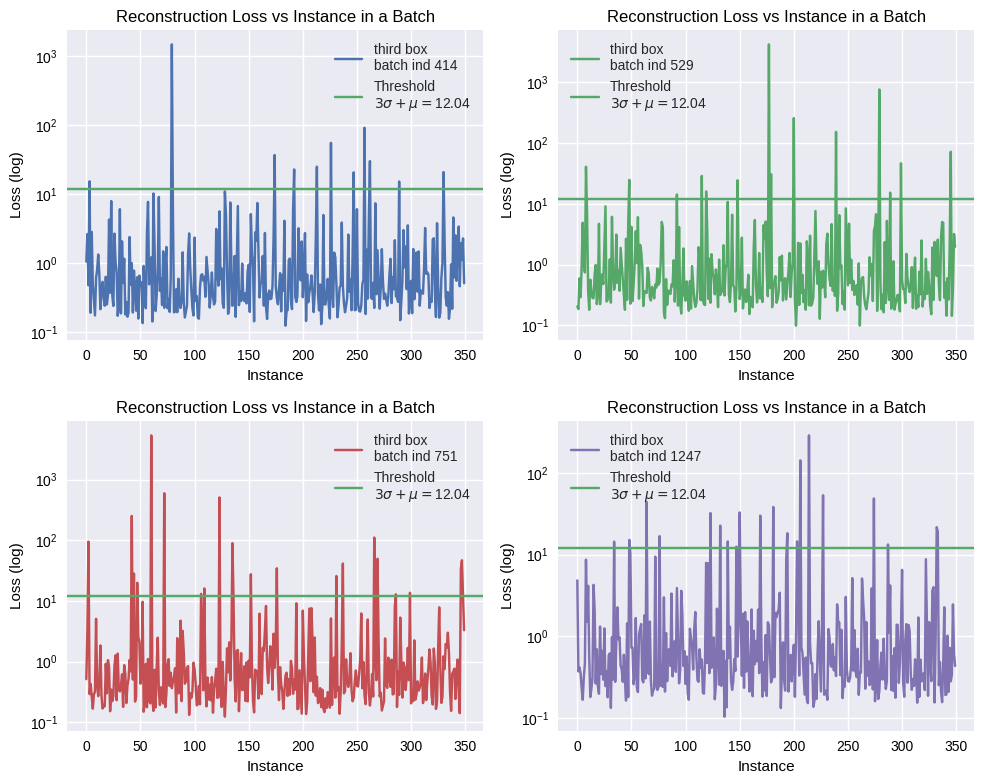

In [27]:
# Closer look at box three.
for (text_color, face_color) in graph_text_face:
    fig, axs = plt.subplots(2, 2, figsize=(10, 8), facecolor=face_color)
    axs = axs.flatten()
    for ind, (key, value) in enumerate(loss_third.items()):
        ax = axs[ind]
        ax.plot(value, label=f'third box\nbatch {key}', color=sns.color_palette()[ind])
        ax.axhline(threshold, color=sns.color_palette()[1], label=f'Threshold\n$3\sigma+\mu=${threshold:.2f}')
        ax.set_title("Reconstruction Loss vs Instance in a Batch", color=text_color)
        ax.set_xlabel("Instance", color=text_color)
        ax.set_ylabel("Loss (log)", color=text_color)
        ax.legend(facecolor=face_color)
        ax.tick_params(axis='both', colors=text_color)
        ax.set_yscale("log")
    plt.tight_layout()
    if save: plt.savefig(f'{data_dir}/graphs/box_three_closer_{face_color}.png', dpi=600, bbox_inches='tight')
    plt.show()